In [1]:
import os
import psutil
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from multiprocessing import Pool, Lock

### Defining the Functions for the Naive Approaches

In [2]:
def GlobalAverage(data):
    return average_rating


def MovieAverage(data):
    movie_id = data['movie_ID']
    movie_id=mov_con[int(np.where(mov_con[:,0]==movie_id)[0][0])][1]
    return mean_rating_per_movie[movie_id]

def UserAverage(data):
    user_id = data['user_ID'] - 1
    return mean_rating_per_user[user_id]


### Reading the Data

In [3]:
file_movie='ml-1m/movies.dat'
file_user = 'ml-1m/users.dat'
file_ratings = 'ml-1m/ratings.dat'
movies_table = pd.read_csv(file_movie, header=None, sep='::', names=['movie_ID','movie_name','movie_genre'],encoding = "ISO-8859-1")
users_table = pd.read_csv(file_user, header=None, sep='::', names = ['user_ID','gender','age','occupation','zipcode'])
ratings_table = pd.read_csv(file_ratings, header=None, sep='::', names = ['user_ID','movie_ID','rating','timestamp'])


/usr/lib64/python3.10/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


The previous cell imports the data from an 'ml-1m' folder <br>
Use the next cell to import the data if they are saved in the same folder as the notebook

In [4]:
'''
movie_file='movies.dat'
user_file = 'users.dat'
ratings_file = 'ratings.dat'
movies_table = pd.read_csv(movie_file, header=None, sep='::', names=['movie_ID','movie_name','movie_genre'],encoding = "ISO-8859-1")
users_table = pd.read_csv(user_file, header=None, sep='::', names = ['user_ID','gender','age','occupation','zipcode'])
ratings_table = pd.read_csv(ratings_file, header=None, sep='::', names = ['user_ID','movie_ID','rating','timestamp'])
data = (users_table, movies_table, ratings_table)
'''

'\nmovie_file=\'movies.dat\'\nuser_file = \'users.dat\'\nratings_file = \'ratings.dat\'\nmovies_table = pd.read_csv(movie_file, header=None, sep=\'::\', names=[\'movie_ID\',\'movie_name\',\'movie_genre\'],encoding = "ISO-8859-1")\nusers_table = pd.read_csv(user_file, header=None, sep=\'::\', names = [\'user_ID\',\'gender\',\'age\',\'occupation\',\'zipcode\'])\nratings_table = pd.read_csv(ratings_file, header=None, sep=\'::\', names = [\'user_ID\',\'movie_ID\',\'rating\',\'timestamp\'])\ndata = (users_table, movies_table, ratings_table)\n'

### Creating the KFold method to do the splitting in order to achieve the 5-fold validation

In [5]:
split_n = 5
kfold = KFold(n_splits=split_n, random_state=1, shuffle=True)

## The Global Average Approach

$R_{global}(User,Item)=mean(all\:ratings) $

In [6]:
time_0=time.time()
train_rmse_1=0
train_mae_1=0
test_rmse_1=0
test_mae_1=0
for train_indices, test_indices in kfold.split(ratings_table):
    train = ratings_table.iloc[train_indices]             #generate the training set
    test = ratings_table.iloc[test_indices]               #generate the test set
    average_rating = train['rating'].mean()               #get the average rating
    
    train_predictions = train.apply(GlobalAverage,axis=1) #use the GlobalAverage function to generate predictions
    test_predictions = test.apply(GlobalAverage, axis=1)  #for the training and test set
    
    train_errors = train['rating'] - train_predictions      #calculate the difference between the real values and 
    train_rmse_1+=np.sqrt(np.mean(np.square(train_errors))) #and the predicted ones and use it to calculate the
    train_mae_1+=np.mean(np.abs(train_errors))              #rmse and mae for the training set adding it each time
                                                            #in ordet to get the total
    
    test_errors = test['rating'] - test_predictions         #do the same for the testing set
    test_rmse_1+=np.sqrt(np.mean(np.square(test_errors))) 
    test_mae_1+=np.mean(np.abs(test_errors))

    
train_rmse_1=train_rmse_1/split_n                          #get the average of the total errors   
train_mae_1=train_mae_1/split_n
test_rmse_1=test_rmse_1/split_n
test_mae_1=test_mae_1/split_n

RunTime_1 = time.time() - time_0                           #get the total time passed
print('Running Time', RunTime_1)

process = psutil.Process(os.getpid())
Memory_1=process.memory_info().rss
print('Memory (in bytes): ',Memory_1)


Running Time 15.330005884170532
Memory (in bytes):  375525376


## The Average Rating per Item Approach

$R_{item}(User,Item)=mean(all\:ratings\:for\:item) $

In [7]:
time_0=time.time()
train_rmse_2=0
train_mae_2=0
test_rmse_2=0
test_mae_2=0
for train_indices, test_indices in kfold.split(ratings_table):
    train = ratings_table.iloc[train_indices]            #generate the training set
    test = ratings_table.iloc[test_indices]              #generate the testing set
    average_rating = train['rating'].mean()              #get the average rating to use as a fallback value
    
    movies=movies_table['movie_ID']                       #get the IDs of all the movies
    movies_idx = np.arange(len(movies))                   #because the IDs table has holes we use a new array to 
    mov_con = np.vstack((movies,movies_idx)).T            #index it properly and use it alongside the movies ID
    
    mean_rating_per_movie = np.empty(len(movies))         #create an empty array to save the average rating of 
                                                          #each movie
    
    for i , movie_id in enumerate(movies):
        movie_subset = train[train['movie_ID'].values == movie_id]  #find all the ratings of each movie 
                                                                    #in the training set
        mean_rating_per_movie[i] = np.mean(movie_subset['rating'])  #get the average of them
        
    mean_rating_per_movie = np.where(np.isnan(mean_rating_per_movie), average_rating, mean_rating_per_movie)
                                                         #if there is no value that means that there were no 
                                                         #ratings for that movie in the training set so we 
                                                         #use the average rating of the whole training set
    
    train_predictions = train.apply(MovieAverage,axis=1) #use the MovieAverage function to generate the predictions
    test_predictions = test.apply(MovieAverage, axis=1)  #for the training and testing set
    
    train_errors = train['rating'] - train_predictions      #calculate the difference between the real values and
    train_rmse_2+=np.sqrt(np.mean(np.square(train_errors))) #and the predicted ones and use it to calculate the
    train_mae_2+=np.mean(np.abs(train_errors))              #rmse and mae for the training set adding it each time
                                                            #in ordet to get the total
    
    test_errors = test['rating'] - test_predictions         #do the same for the testing set
    test_rmse_2+=np.sqrt(np.mean(np.square(test_errors))) 
    test_mae_2+=np.mean(np.abs(test_errors))

    
train_rmse_2=train_rmse_2/split_n                       #get the average of the total errors   
train_mae_2=train_mae_2/split_n
test_rmse_2=test_rmse_2/split_n
test_mae_2=test_mae_2/split_n

RunTime_2 = time.time() - time_0                       #get the total time passed
print('Running Time', RunTime_2)

process = psutil.Process(os.getpid())
Memory_2=process.memory_info().rss
print('Memory (in bytes): ',Memory_2)


Running Time 88.70664620399475
Memory (in bytes):  389423104


## The Average Rating per User Approach

$R_{user}(User,Item)=mean(all\:ratings\:for\:user) $

In [8]:
time_0=time.time()
train_rmse_3=0
train_mae_3=0
test_rmse_3=0
test_mae_3=0
for train_indices, test_indices in kfold.split(ratings_table):
    train = ratings_table.iloc[train_indices]            #generate the training set
    test = ratings_table.iloc[test_indices]              #generate the testing set
    average_rating = train['rating'].mean()              #get the average rating to use as a fallback value
    
    mean_rating_per_user = np.empty(len(users_table['user_ID'])) #create an empty array to save the average 
                                                                  #rating of each user
    
    for i , user_id in enumerate(users_table['user_ID']):
        user_subset = train[train['user_ID'].values == user_id]  #find all the ratings of each user in the 
                                                                 #training set
        mean_rating_per_user[i] = np.mean(user_subset['rating']) #get the average of them
        
    mean_rating_per_user = np.where(np.isnan(mean_rating_per_user), average_rating, mean_rating_per_user)
                                                         #if there is no value that means that there were no 
                                                         #ratings for that user in the training set so we 
                                                         #use the average rating of the whole training set

    
    train_predictions = train.apply(UserAverage,axis=1) #use the UserAverage function to generate the predictions
    test_predictions = test.apply(UserAverage, axis=1)  #for the training and testing set
    
    train_errors = train['rating'] - train_predictions      #calculate the difference between the real values and
    train_rmse_3+=np.sqrt(np.mean(np.square(train_errors))) #and the predicted ones and use it to calculate the
    train_mae_3+=np.mean(np.abs(train_errors))              #rmse and mae for the training set adding it each time
                                                            #in ordet to get the total
    
    test_errors = test['rating'] - test_predictions         #do the same for the testing set
    test_rmse_3+=np.sqrt(np.mean(np.square(test_errors))) 
    test_mae_3+=np.mean(np.abs(test_errors))

    
train_rmse_3=train_rmse_3/split_n                    #get the average of the total errors
train_mae_3=train_mae_3/split_n
test_rmse_3=test_rmse_3/split_n
test_mae_3=test_mae_3/split_n

RunTime_3 = time.time() - time_0                     #get the total time passed
print('Running Time', RunTime_3)

process = psutil.Process(os.getpid())
Memory_3=process.memory_info().rss
print('Memory (in bytes): ',Memory_3)


Running Time 55.217570304870605
Memory (in bytes):  389443584


## Linear Regression Model with the Intercept Parameter $\gamma$

$ R_{user-item}(User,Item)=\alpha \cdot R_{user}(User,Item) + \beta \cdot R_{item}(User,Item) +\gamma $

In [9]:
time_0=time.time()
train_rmse_4=0
train_mae_4=0
test_rmse_4=0
test_mae_4=0    



users=users_table['user_ID']

movies=movies_table['movie_ID']            #get the IDs of all the movies
movies_idx = np.arange(len(movies))        #because the IDs table has holes we use a new array to
mov_con = np.vstack((movies,movies_idx)).T #index it properly and use it alongside the movies ID

for train_index, test_index in kfold.split(ratings_table):
    train = ratings_table.iloc[train_index] #generate the training set
    test = ratings_table.iloc[test_index]   #generate the testing set
    average_rating = train['rating'].mean() #get the average rating to use as a fallback value
    
    mean_rating_per_user = np.empty(len(users_table))            #create an empty array to save the average 
                                                                 #rating of each user
    for i , user_id in enumerate(users_table['user_ID']):
        user_subset = train[train['user_ID'].values == user_id]  #find all the ratings of each user in the
                                                                 #training set
        mean_rating_per_user[i] = np.mean(user_subset['rating']) #get the average of them
                                                                 
        
    mean_rating_per_user = np.where(np.isnan(mean_rating_per_user), average_rating, mean_rating_per_user)
                                                             #if there is no value that means that there were no 
                                                             #ratings for that user in the training set so we 
                                                             #use the average rating of the whole training set
    
    user_id_rating=np.vstack((users,mean_rating_per_user)).T     #create an array of all the users 
                                                            #and their average rating
    
    
    
    mean_rating_per_movie = np.empty(len(movies)) #create an empty array to save the average rating of #each movie
                                                          
    for i , movie_id in enumerate(movies):
        movie_subset = train[train['movie_ID'].values == movie_id]  #find all the ratings of each movie 
                                                                    #in the training set
        mean_rating_per_movie[i] = np.mean(movie_subset['rating'])  #get the average of them
        

    mean_rating_per_movie = np.where(np.isnan(mean_rating_per_movie), average_rating, mean_rating_per_movie)
                                                           #if there is no value that means that there were no 
                                                           #ratings for that movie in the training set so we 
                                                           #use the average rating of the whole training set
    
    movie_id_rating=np.vstack((movies,mean_rating_per_movie)).T #create an array of all the movies 
                                                           #and their average rating
    
    #for each rating in the training set we need the value of the average rating for this movie and for this user
    
    #this finds the average user rating for each rating in the training set
    users_mean_rating=np.empty(len(train['user_ID']))      
    for i , user_id in enumerate(train['user_ID']):
        mean=user_id_rating[int(np.where(user_id_rating[:,0].astype(int)==user_id)[0][0])][1]
        users_mean_rating[i]=mean
    
    #this finds the average movie rating for each rating in the training set
    movies_mean_rating=np.empty(len(train['movie_ID']))
    for i , movie_id in enumerate(train['movie_ID']):
        mean=movie_id_rating[int(np.where(movie_id_rating[:,0].astype(int)==movie_id)[0][0])][1]
        movies_mean_rating[i]=mean
    
    #combine the two sets to use them in the LinearRegression
    fitting_list = np.vstack((users_mean_rating,movies_mean_rating)).T
        
    #Use the LinearRegression with fit_intercept=True because we want an intercept in the line
    regression = LinearRegression(fit_intercept=True).fit(fitting_list, train['rating'])
    
    
    train_predictions = regression.predict(fitting_list) #generate predictions for the training set
    
    train_predictions[train_predictions>5]=5  #round the values bigger than 5 to 5
    train_predictions[train_predictions<1]=1  #and smaller than 1 to 1
    
    train_errors = train['rating'] - train_predictions      #calculate the difference between the real values and
    train_rmse_4+=np.sqrt(np.mean(np.square(train_errors))) #and the predicted ones and use it to calculate the
    train_mae_4+=np.mean(np.abs(train_errors))              #rmse and mae for the training set adding it each time
                                                            #in ordet to get the total
        
    
    #Now we have to create the same lists for the testing set as we did for the training set in order to be 
    #able to generate predictions and test the accuracy on the testing set
    
    
    test_mean_rating_per_user = np.empty(len(users_table['user_ID'])) #create an empty array to save the average
                                                                      #rating of each user for the testing set
    for i , user_id in enumerate(users_table['user_ID']):             
        test_user_subset = train[train['user_ID'].values == user_id]  #find all the ratings of each movie in the
                                                                      #training set because we will generate the
                                                                      #predictions based on that
        test_mean_rating_per_user[i] = np.mean(test_user_subset['rating']) #get the average
        
        
    test_mean_rating_per_user = np.where(np.isnan(test_mean_rating_per_user), average_rating, 
                                         test_mean_rating_per_user) 
                                    #if there is no value that means that there were no ratings for that user
                                    #in the training set so we use the average rating of the whole training set
    
    test_user_id_rating=np.vstack((users,test_mean_rating_per_user)).T
    
    
    
    test_mean_rating_per_movie = np.empty(len(movies))              #create an empty array to save the average
                                                                    #rating of each movie for the testing set
    
    for i , movie_id in enumerate(movies):
        test_movie_subset = train[train['movie_ID'].values == movie_id] #find all the ratings of each movie in the
                                                                        #training set because we will generate the
                                                                        #predictions based on that
        test_mean_rating_per_movie[i] = np.mean(test_movie_subset['rating'])  #get the average
        
        
    test_mean_rating_per_movie = np.where(np.isnan(test_mean_rating_per_movie), average_rating
                                          , test_mean_rating_per_movie)
                                    #if there is no value that means that there were no ratings for that user
                                    #in the training set so we use the average rating of the whole training set
    
    
    test_movie_id_rating=np.vstack((movies,test_mean_rating_per_movie)).T
    
    
    #for each rating in the training set we need the value of the average rating 
    #for this movie and for this user in the training set
    
    #this finds the average user rating for each rating in the training set
    test_users_mean_rating=np.empty(len(test['user_ID']))
    for i , user_id in enumerate(test['user_ID']):
        mean=test_user_id_rating[int(np.where(test_user_id_rating[:,0].astype(int)==user_id)[0][0])][1] 
        test_users_mean_rating[i]=mean
    
    #this finds the average movie rating for each rating in the training set
    test_movies_mean_rating=np.empty(len(test['movie_ID']))
    for i , movie_id in enumerate(test['movie_ID']):
        mean=test_movie_id_rating[int(np.where(test_movie_id_rating[:,0].astype(int)==movie_id)[0][0])][1]
        test_movies_mean_rating[i]=mean
    
    #combine the two sets to use them in the regression.predict
    test_fitting_list = np.vstack((test_users_mean_rating,test_movies_mean_rating)).T
    
    test_predictions = regression.predict(test_fitting_list) #generate predictions for the testing set
    
    test_predictions[test_predictions>5]=5 #round the values bigger than 5 to 5
    test_predictions[test_predictions<1]=1 #and smaller than 1 to 1
    
    test_errors = test['rating'] - test_predictions       #calculate the difference between the real values and
    test_rmse_4+=np.sqrt(np.mean(np.square(test_errors))) #and the predicted ones and use it to calculate the
    test_mae_4+=np.mean(np.abs(test_errors))              #rmse and mae for the training set adding it each time
                                                          #in ordet to get the total
    
    
    
train_rmse_4=train_rmse_4/split_n                      #get the average of the total errors
train_mae_4=train_mae_4/split_n
test_rmse_4=test_rmse_4/split_n
test_mae_4=test_mae_4/split_n

RunTime_4 = time.time() - time_0                       #get the total time passed
print('Running Time', RunTime_4)

process = psutil.Process(os.getpid())
Memory_4=process.memory_info().rss
print('Memory (in bytes): ',Memory_4)

Running Time 178.77781987190247
Memory (in bytes):  416600064


## Linear Regression Model without the Intercept Parameter $\gamma$

$ R_{user-item}(User,Item)=\alpha \cdot R_{user}(User,Item) + \beta \cdot R_{item}(User,Item) $

In [10]:
time_0=time.time()
train_rmse_5=0
train_mae_5=0
test_rmse_5=0
test_mae_5=0    



users=users_table['user_ID']

movies=movies_table['movie_ID']            #get the IDs of all the movies
movies_idx = np.arange(len(movies))        #because the IDs table has holes we use a new array to
mov_con = np.vstack((movies,movies_idx)).T #index it properly and use it alongside the movies ID

for train_index, test_index in kfold.split(ratings_table):
    train = ratings_table.iloc[train_index] #generate the training set
    test = ratings_table.iloc[test_index]   #generate the testing set
    average_rating = train['rating'].mean() #get the average rating to use as a fallback value
    
    mean_rating_per_user = np.empty(len(users_table))            #create an empty array to save the average 
                                                                 #rating of each user
    for i , user_id in enumerate(users_table['user_ID']):
        user_subset = train[train['user_ID'].values == user_id]  #find all the ratings of each user in the
                                                                 #training set
        mean_rating_per_user[i] = np.mean(user_subset['rating']) #get the average of them
                                                                 
        
    mean_rating_per_user = np.where(np.isnan(mean_rating_per_user), average_rating, mean_rating_per_user)
                                                             #if there is no value that means that there were no 
                                                             #ratings for that user in the training set so we 
                                                             #use the average rating of the whole training set
    
    user_id_rating=np.vstack((users,mean_rating_per_user)).T     #create an array of all the users 
                                                            #and their average rating
    
    
    
    mean_rating_per_movie = np.empty(len(movies)) #create an empty array to save the average rating of #each movie
                                                          
    for i , movie_id in enumerate(movies):
        movie_subset = train[train['movie_ID'].values == movie_id]  #find all the ratings of each movie 
                                                                    #in the training set
        mean_rating_per_movie[i] = np.mean(movie_subset['rating'])  #get the average of them
        

    mean_rating_per_movie = np.where(np.isnan(mean_rating_per_movie), average_rating, mean_rating_per_movie)
                                                           #if there is no value that means that there were no 
                                                           #ratings for that movie in the training set so we 
                                                           #use the average rating of the whole training set
    
    movie_id_rating=np.vstack((movies,mean_rating_per_movie)).T #create an array of all the movies 
                                                           #and their average rating
    
    #for each rating in the training set we need the value of the average rating for this movie and for this user
    
    #this finds the average user rating for each rating in the training set
    users_mean_rating=np.empty(len(train['user_ID']))      
    for i , user_id in enumerate(train['user_ID']):
        mean=user_id_rating[int(np.where(user_id_rating[:,0].astype(int)==user_id)[0][0])][1]
        users_mean_rating[i]=mean
    
    #this finds the average movie rating for each rating in the training set
    movies_mean_rating=np.empty(len(train['movie_ID']))
    for i , movie_id in enumerate(train['movie_ID']):
        mean=movie_id_rating[int(np.where(movie_id_rating[:,0].astype(int)==movie_id)[0][0])][1]
        movies_mean_rating[i]=mean
    
    #combine the two sets to use them in the LinearRegression
    fitting_list = np.vstack((users_mean_rating,movies_mean_rating)).T
        
    #Use the LinearRegression with fit_intercept=False because we don't want an intercept in the line
    regression = LinearRegression(fit_intercept=False).fit(fitting_list, train['rating'])
    
    
    train_predictions = regression.predict(fitting_list) #generate predictions for the training set
    
    train_predictions[train_predictions>5]=5  #round the values bigger than 5 to 5
    train_predictions[train_predictions<1]=1  #and smaller than 1 to 1
    
    train_errors = train['rating'] - train_predictions      #calculate the difference between the real values and
    train_rmse_5+=np.sqrt(np.mean(np.square(train_errors))) #and the predicted ones and use it to calculate the
    train_mae_5+=np.mean(np.abs(train_errors))              #rmse and mae for the training set adding it each time
                                                            #in ordet to get the total
        
    
    #Now we have to create the same lists for the testing set as we did for the training set in order to be 
    #able to generate predictions and test the accuracy on the testing set
    
    
    test_mean_rating_per_user = np.empty(len(users_table['user_ID'])) #create an empty array to save the average
                                                                      #rating of each user for the testing set
    for i , user_id in enumerate(users_table['user_ID']):             
        test_user_subset = train[train['user_ID'].values == user_id]  #find all the ratings of each movie in the
                                                                      #training set because we will generate the
                                                                      #predictions based on that
        test_mean_rating_per_user[i] = np.mean(test_user_subset['rating']) #get the average
        
        
    test_mean_rating_per_user = np.where(np.isnan(test_mean_rating_per_user), average_rating, 
                                         test_mean_rating_per_user) 
                                    #if there is no value that means that there were no ratings for that user
                                    #in the training set so we use the average rating of the whole training set
    
    test_user_id_rating=np.vstack((users,test_mean_rating_per_user)).T
    
    
    
    test_mean_rating_per_movie = np.empty(len(movies))              #create an empty array to save the average
                                                                    #rating of each movie for the testing set
    
    for i , movie_id in enumerate(movies):
        test_movie_subset = train[train['movie_ID'].values == movie_id] #find all the ratings of each movie in the
                                                                        #training set because we will generate the
                                                                        #predictions based on that
        test_mean_rating_per_movie[i] = np.mean(test_movie_subset['rating'])  #get the average
        
        
    test_mean_rating_per_movie = np.where(np.isnan(test_mean_rating_per_movie), average_rating
                                          , test_mean_rating_per_movie)
                                    #if there is no value that means that there were no ratings for that user
                                    #in the training set so we use the average rating of the whole training set
    
    
    test_movie_id_rating=np.vstack((movies,test_mean_rating_per_movie)).T
    
    
    #for each rating in the training set we need the value of the average rating 
    #for this movie and for this user in the training set
    
    #this finds the average user rating for each rating in the training set
    test_users_mean_rating=np.empty(len(test['user_ID']))
    for i , user_id in enumerate(test['user_ID']):
        mean=test_user_id_rating[int(np.where(test_user_id_rating[:,0].astype(int)==user_id)[0][0])][1] 
        test_users_mean_rating[i]=mean
    
    #this finds the average movie rating for each rating in the training set
    test_movies_mean_rating=np.empty(len(test['movie_ID']))
    for i , movie_id in enumerate(test['movie_ID']):
        mean=test_movie_id_rating[int(np.where(test_movie_id_rating[:,0].astype(int)==movie_id)[0][0])][1]
        test_movies_mean_rating[i]=mean
    
    #combine the two sets to use them in the regression.predict
    test_fitting_list = np.vstack((test_users_mean_rating,test_movies_mean_rating)).T
    
    test_predictions = regression.predict(test_fitting_list) #generate predictions for the testing set
    
    test_predictions[test_predictions>5]=5 #round the values bigger than 5 to 5
    test_predictions[test_predictions<1]=1 #and smaller than 1 to 1
    
    test_errors = test['rating'] - test_predictions       #calculate the difference between the real values and
    test_rmse_5+=np.sqrt(np.mean(np.square(test_errors))) #and the predicted ones and use it to calculate the
    test_mae_5+=np.mean(np.abs(test_errors))              #rmse and mae for the training set adding it each time
                                                          #in ordet to get the total
    
    
    
train_rmse_5=train_rmse_5/split_n                      #get the average of the total errors
train_mae_5=train_mae_5/split_n
test_rmse_5=test_rmse_5/split_n
test_mae_5=test_mae_5/split_n

RunTime_5 = time.time() - time_0                       #get the total time passed
print('Running Time', RunTime_5)

process = psutil.Process(os.getpid())
Memory_5=process.memory_info().rss
print('Memory (in bytes): ',Memory_5)

Running Time 172.2744264602661
Memory (in bytes):  447537152


### Saving results in a pandas dataframe

In [11]:
def printing_df(styler):
        styler.hide(axis='index')
        styler.format(precision=3)
        return styler

In [12]:
d = {'Model': ['Global Average', 'Movie Average', 'User Average' , 'Lin Reg with intercept' , 'Lin Reg without intercept'], 
     'RMSE Training': [train_rmse_1, train_rmse_2, train_rmse_3, train_rmse_4, train_rmse_5], 
    'RMSE Testing': [test_rmse_1, test_rmse_2, test_rmse_3, test_rmse_4, test_rmse_5], 
    'MAE Training': [train_mae_1, train_mae_2, train_mae_3, train_mae_4, train_mae_5], 
    'MAE Testing': [test_mae_1, test_mae_2, test_mae_3, test_mae_4, test_mae_5],
    'Running Time': [RunTime_1,RunTime_2,RunTime_3,RunTime_4,RunTime_5],
    'Memory': [Memory_1/(1e6),Memory_2/(1e6),Memory_3/(1e6),Memory_4/(1e6),Memory_5/(1e6)]}
results=pd.DataFrame(d)


In [13]:
#results.style.pipe(printing_df)

In [14]:
#results.style.pipe(printing_df).to_latex()

In [42]:
results.to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\n                    Model &  RMSE Training &  RMSE Testing &  MAE Training &  MAE Testing &  Running Time &     Memory \\\\\n\\midrule\n           Global Average &       1.117101 &      1.117101 &      0.933861 &     0.933861 &     15.330006 & 375.525376 \\\\\n            Movie Average &       0.974211 &      0.979527 &      0.778343 &     0.782385 &     88.706646 & 389.423104 \\\\\n             User Average &       1.027672 &      1.035489 &      0.822732 &     0.829008 &     55.217570 & 389.443584 \\\\\n   Lin Reg with intercept &       0.914544 &      0.924395 &      0.724800 &     0.732557 &    178.777820 & 416.600064 \\\\\nLin Reg without intercept &       0.946550 &      0.952529 &      0.758551 &     0.763207 &    172.274426 & 447.537152 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [15]:
results_sorted=results.sort_values(by=['RMSE Testing'],ascending=False)

### Plotting

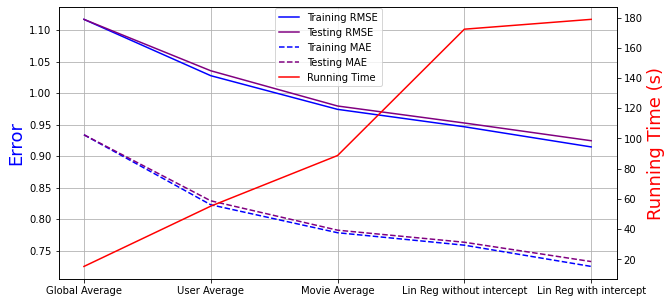

In [59]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(results_sorted['Model'],results_sorted['RMSE Training'],color='b',label='Training RMSE')
ax1.plot(results_sorted['Model'],results_sorted['RMSE Testing'],color='purple',label='Testing RMSE')
ax1.plot(results_sorted['Model'],results_sorted['MAE Training'],color='b',linestyle='--',label='Training MAE')
ax1.plot(results_sorted['Model'],results_sorted['MAE Testing'],color='purple',linestyle='--',label='Testing MAE')
ax2.plot(results_sorted['Model'],results_sorted['Running Time'],color='r',label='Running Time')
#ax1.set_xlabel('Model')
ax1.set_ylabel('Error', color='b',fontsize=18)
ax2.set_ylabel('Running Time (s)', color='r',fontsize=18)
ax1.grid()
fig.legend(loc=9,bbox_to_anchor=(0.50,0.89))
plt.savefig('task1_time.png')
plt.show()

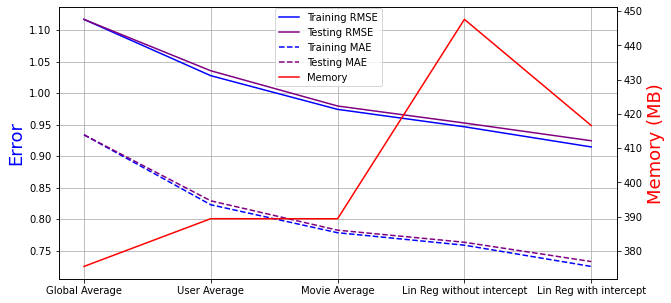

In [60]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(results_sorted['Model'],results_sorted['RMSE Training'],color='b',label='Training RMSE')
ax1.plot(results_sorted['Model'],results_sorted['RMSE Testing'],color='purple',label='Testing RMSE')
ax1.plot(results_sorted['Model'],results_sorted['MAE Training'],color='b',linestyle='--',label='Training MAE')
ax1.plot(results_sorted['Model'],results_sorted['MAE Testing'],color='purple',linestyle='--',label='Testing MAE')
ax2.plot(results_sorted['Model'],results_sorted['Memory'],color='r',label='Memory')
ax1.set_ylabel('Error', color='b',fontsize=18)
ax2.set_ylabel('Memory (MB)', color='r',fontsize=18)
ax1.grid()
fig.legend(loc=9,bbox_to_anchor=(0.50,0.89))
plt.savefig('task1_memory.png')
plt.show()

# UV Decomposition

In [18]:
M = ratings_table.pivot(index = 'user_ID', columns= 'movie_ID', values='rating')
M_shape=np.shape(M)

print(M_shape[0])
print(M_shape[1])
data = (users_table, movies_table, ratings_table)

6040
3706


## Defining the functions

In [19]:
#### functions for calculating errors


def UV_rmse(U,V,M):  #Calculates RMSE
    #matrix_product = np.dot(U,V)
    #print(np.shape(matrix_product))
    matrix_product = np.matmul(U,V)
    #print(np.shape(matrix_product))
    nonzero = np.count_nonzero(~np.isnan(matrix_product-M))
    RMSE = np.sqrt(np.nansum((matrix_product-M)**2)/nonzero)
    return RMSE
def UV_mae(U,V,M): #Calculates MAE
    matrix_product = np.matmul(U,V)
    nonzero = np.count_nonzero(~np.isnan(matrix_product-M))
    MAE = np.sqrt(np.nansum(np.abs(matrix_product-M))/nonzero)
    return MAE

In [20]:
#page 347
def UV_ini(table):  # Function for getting the global mean for the initial value in the UV matrix in decomposition.

    U = np.random.uniform(np.sqrt(np.mean(table)/2), np.sqrt(np.mean(table)/2), (6040,2))
    V = np.random.uniform(np.sqrt(np.mean(table)/2), np.sqrt(np.mean(table)/2), (2,3952))
    return U,V
def update_U(U, V, M): #updating rows

    n = np.arange(len(U))
    m = np.arange(len(U[0]))
    for row in n:
        for col in m:

            sum_array = np.matmul(U[row, :] , V[:]) - (U[row, col] * V[col, :])

            sub = M[row, :] - sum_array

            
            v_array = np.array(V[col, :])
            v_array[np.isnan(M[row, :])] = np.nan

            
            U[row, col] = (U[row, col] + (np.nansum(V[col, :] * sub) / np.nansum(np.square(v_array)))) / 2
            
            
def update_V(U, V, M):  #updating columns

    n = np.arange(len(V))
    m = np.arange(len(V[0]))
    for row in n:
        for col in m:

            sum_array = np.matmul(U[:], V[:, col]) - (U[:, row] * V[row, col])

            sub = M[:, col] - sum_array

            
            u_array = np.array(U[:, row])
            u_array[np.isnan(M[:, col])] = np.nan
            
            
            V[row, col] = (V[row, col] + (np.nansum(U[:, row] * sub) / (np.nansum(np.square(u_array))))) / 2




In [21]:
# A function that creates an array out of a given table           
def table_to_array(data):
    users_table, movies_table, ratings_table = data
    #cv = KFold(n_splits=5, random_state=1, shuffle=True)     #splitting into 5fold
    
    array_train = []
    array_test = []
    


    for idx_train, idx_test in kfold.split(ratings_table):
        train = ratings_table.iloc[idx_train]
        test = ratings_table.iloc[idx_test]
        #Train array with a number of rows equal to user (6040) and columns (3952) equal to movie
        nan_array_train = np.full((6040, 3952), np.nan)
        #Test array with a number of rows equal to user (6040) and columns (3952) equal to movie
        nan_array_test = np.full((6040, 3952), np.nan)

        for i in range (len(train)):
            rating = train.iloc[i]
            nan_array_train[rating['user_ID'] - 1][rating['movie_ID'] - 1] = rating['rating']

        for j in range (len(test)):
            rating = test.iloc[j]
            nan_array_test[rating['user_ID'] - 1][rating['movie_ID'] - 1] = rating['rating']

        array_train.append(nan_array_train)
        array_test.append(nan_array_test)
    return array_train,array_test

In [22]:
def uv_decomposition(matrices_train, matrices_test):



    U, V = UV_ini(ratings_table['rating'])

    steps = 20  #number of steps, can be changed
    fold = 5
    
    rmse_list_train_mean = np.empty(steps)
    mae_list_train_mean = np.empty(steps)
    rmse_list_test_mean = np.empty(steps)
    mae_list_test_mean = np.empty(steps)
    
    for i in range (steps):  
        for j in range (fold):
            rmse_list_train = []
            mae_list_train = []
            rmse_list_test = []
            mae_list_test = []
            
            update_U(U, V, matrices_train[j])
            update_V(U, V, matrices_train[j])
            
            rmse_train = UV_rmse(U, V, matrices_train[j])
            mae_train = UV_mae(U, V, matrices_train[j])
            rmse_test=  UV_rmse(U, V, matrices_test[j])
            mae_test = UV_mae(U, V, matrices_test[j])
            
            
            rmse_list_train.append(rmse_train)
            mae_list_train.append(mae_train)
            rmse_list_test.append(rmse_test)
            mae_list_test.append(mae_test)
            
            print('progress: ',i+1,'out of 20',j+1, 'out of 5')
            
        rmse_list_train_mean[i]=np.mean(np.array(rmse_list_train))
        mae_list_train_mean[i]=np.mean(np.array(mae_list_train))
        rmse_list_test_mean[i]=np.mean(np.array(rmse_list_test))
        mae_list_test_mean[i]=np.mean(np.array(mae_list_test))
        

    
    return rmse_list_train_mean, mae_list_train_mean, rmse_list_test_mean, mae_list_test_mean

## Converting tables to matrices 

In [23]:
initial_t = time.time()

array_train, array_test = table_to_array(data)
array_time = time.time() - initial_t
print('Execution time (s) of generating an array from a table', array_time)
process = psutil.Process(os.getpid())
print('memory (bytes): ',process.memory_info().rss)

Execution time (s) of generating an array from a table 318.64457082748413
memory (bytes):  2535415808


## Running the UV decomposition algorithm

In [24]:
initial_t = time.time()
rmse_train, mae_train, rmse_test, mae_test = uv_decomposition(array_train,
                                                              array_test)
                                                             
                                                             
best_rmse_train_uv = np.min(rmse_train)
best_rmse_test_uv = np.min(rmse_test)
best_mae_train_uv = np.min(mae_train)
best_mae_test_uv = np.min(mae_test)
print('RMSE train:', best_rmse_train_uv)
print('MAE train', best_mae_train_uv)
print('RMSE test', best_rmse_test_uv)
print('MAE train', best_mae_test_uv)
uv_dec_time =time.time() - initial_t
print('Execution time (s) of the UV decomposition:', uv_dec_time)


time_uv = uv_dec_time + array_time
print('Overall execution time (s) :', np.round(time_uv, decimals = 3))

process = psutil.Process(os.getpid())
memory_uv=process.memory_info().rss
print('memory (bytes): ',memory_uv)

<ipython-input-20-2fcfcd937ebd>:42: RuntimeWarning: invalid value encountered in double_scalars
  V[row, col] = (V[row, col] + (np.nansum(U[:, row] * sub) / (np.nansum(np.square(u_array))))) / 2


progress:  1 out of 20 1 out of 5
progress:  1 out of 20 2 out of 5
progress:  1 out of 20 3 out of 5
progress:  1 out of 20 4 out of 5
progress:  1 out of 20 5 out of 5
progress:  2 out of 20 1 out of 5
progress:  2 out of 20 2 out of 5
progress:  2 out of 20 3 out of 5
progress:  2 out of 20 4 out of 5
progress:  2 out of 20 5 out of 5
progress:  3 out of 20 1 out of 5
progress:  3 out of 20 2 out of 5
progress:  3 out of 20 3 out of 5
progress:  3 out of 20 4 out of 5
progress:  3 out of 20 5 out of 5
progress:  4 out of 20 1 out of 5
progress:  4 out of 20 2 out of 5
progress:  4 out of 20 3 out of 5
progress:  4 out of 20 4 out of 5
progress:  4 out of 20 5 out of 5
progress:  5 out of 20 1 out of 5
progress:  5 out of 20 2 out of 5
progress:  5 out of 20 3 out of 5
progress:  5 out of 20 4 out of 5
progress:  5 out of 20 5 out of 5
progress:  6 out of 20 1 out of 5
progress:  6 out of 20 2 out of 5
progress:  6 out of 20 3 out of 5
progress:  6 out of 20 4 out of 5
progress:  6 o

## Plotting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


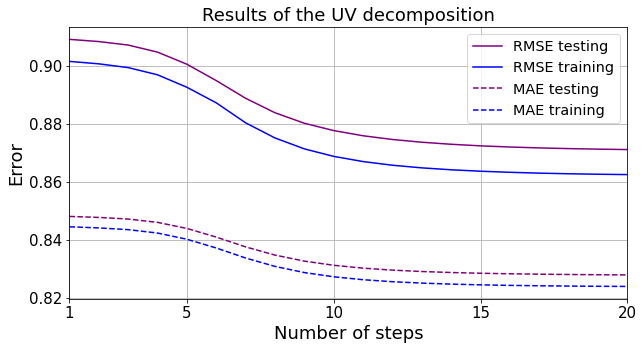

In [61]:
num=20
steps = np.linspace(1,num,num)
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(steps,rmse_test,label='RMSE testing', c='purple', linestyle='-')
plt.plot(steps,rmse_train,label='RMSE training',c='blue', linestyle='-')
plt.plot(steps,mae_test,label='MAE testing', c='purple', linestyle='--')
plt.plot(steps,mae_train,label='MAE training', c='blue', linestyle='--')



plt.xlabel('Number of steps', fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.title('Results of the UV decomposition', fontsize=18)

plt.legend(fontsize='x-large')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlim(1,num)
plt.xticks([1, 5, 10, 15, 20])
plt.grid()
plt.savefig('uv.png')
plt.show()

# Matrix Factorization

## Defining the functions

In [26]:
def normalise_rating(ratings):
    #set values greater than 5 to 5 and less than 1 to 1
    ratings_n = np.where(ratings > 5.0, 5.0, ratings)
    ratings_n = np.where(ratings_n < 1.0, 1.0, ratings_n)
    return ratings_n

In [27]:
mp_lock = Lock()
def matrix_factorization_error(ratings, train_index, test_index, users, movies, factors, n_training_steps, learning_rate, lamda):

    User_Matrix = np.random.normal(0.0, 1.0, ((len(users), factors)))
    Movie_Matrix = np.random.normal(0.0, 1.0, ((factors, len(movies))))
    
    train_set = ratings.iloc[train_index]
    test_set = ratings.iloc[test_index]

    # index for every user ID
    train_user_indices = train_set['user_ID'].values - 1
    test_user_indices = test_set['user_ID'].values - 1

    # index for every movie ID
    movie_ids = movies['movie_ID'].values

    train_movie_ids = train_set['movie_ID'].values - 1

    ids_to_ind_train = np.array([], dtype=np.int32)
    s_int_train = 0
    for i in np.arange(len(movie_ids)):
        if movie_ids[i] == i + 1 + s_int_train :
            ids_to_ind_train = np.append(ids_to_ind_train, i)
        else:
            while movie_ids[i] != i + 1 + s_int_train :
                ids_to_ind_train = np.append(ids_to_ind_train, 0)
                s_int_train += 1
            ids_to_ind_train = np.append(ids_to_ind_train, i)
    
    train_movie_indices = ids_to_ind_train[train_movie_ids] #ID to indices

    test_movie_ids = test_set['movie_ID'].values - 1
    ids_to_ind_test= np.array([], dtype=np.int32)
    s_int_test = 0
    for j in np.arange(len(movie_ids)):
        if movie_ids[j] == j + 1 + s_int_test :
            ids_to_ind_test = np.append(ids_to_ind_test, j)
        else:
            while movie_ids[j] != j + 1 + s_int_test :
                ids_to_ind_test = np.append(ids_to_ind_test, 0)
                s_int_test += 1
            ids_to_ind_test = np.append(ids_to_ind_test, j)
    
    test_movie_indices = ids_to_ind_test[test_movie_ids] 

    # Create a matrix 
    train_set_rating_matrix = np.zeros((len(users), len(movies))) # matrix [U,M] 
    for u, m, rating in zip(train_user_indices, train_movie_indices, train_set['rating']):
        train_set_rating_matrix[u, m] = rating

    

    errors = np.empty((0, 4))

    for step in range(n_training_steps):
        # Calculate the errors of the ratings predicted by the dot product of User matrix and Movie matrix
        predicted_ratings = np.dot(User_Matrix, Movie_Matrix)

        train_set_predicted_ratings = predicted_ratings[train_user_indices, train_movie_indices]
        test_set_predicted_ratings = predicted_ratings[test_user_indices, test_movie_indices]

        train_errors = train_set['rating'] - normalise_rating(train_set_predicted_ratings)
        test_errors = test_set['rating'] - normalise_rating(test_set_predicted_ratings)
        
        #calculate root means square error
        train_rmse = np.sqrt(np.mean(np.square(train_errors)))
        test_rmse = np.sqrt(np.mean(np.square(test_errors)))

        #calculate mean absolute error
        train_mae = np.mean(np.abs(train_errors))
        test_mae = np.mean(np.abs(test_errors))
        
        errors = np.append(errors, np.array([[train_rmse, test_rmse, train_mae, test_mae]]), axis=0)

        mp_lock.acquire()
        print('Step: ', step)
        print('Train Set Root Mean Square Error: ', train_rmse, ' Test Set Root Mean Square Error ', test_rmse)
        print('Train set  Mean Absolute Error ', train_mae, ' Test Set Mean Absolute Error ', test_mae)
        mp_lock.release()
        
        # Update the users and movies matrix
        for u, m in zip(train_user_indices, train_movie_indices):
            u_vector, m_vector = User_Matrix[u, :], Movie_Matrix[:, m]
            error = train_set_rating_matrix[u, m] - np.dot(u_vector, m_vector)
            User_Matrix[u, :] += learning_rate * (2 * error * m_vector - lamda * u_vector)
            Movie_Matrix[:, m] += learning_rate * (2 * error * User_Matrix[u, :] - lamda * m_vector)
        
        
        #save the matrix for use in the visualization part
        np.save('U_1.npy', User_Matrix)
        np.save('M_1.npy', Movie_Matrix)
    return errors



In [28]:
data = (users_table, movies_table, ratings_table)
users, movies, ratings = data

## Running the matrix factorization algorithm

In [29]:
t0 = time.time()


factors=10
n_training_steps=75
lamda=0.05
learning_rate=0.005
n_folds=5

params = [(ratings,train_index, test_index, users, 
            movies, factors, n_training_steps, learning_rate, lamda) 
            for train_index, test_index in kfold.split(ratings)]

pool = Pool(n_folds)
fold_errors = pool.starmap(matrix_factorization_error, params)
pool.close()
pool.join()
    
# [n_folds, n_training_steps, n_error_types]
errors =  np.transpose(np.array(fold_errors), (0, 2, 1))

mean_train_rmses = np.mean(errors, axis=0)[0]
mean_test_rmses = np.mean(errors, axis=0)[1]
mean_train_maes = np.mean(errors, axis=0)[2]
mean_test_maes = np.mean(errors, axis=0)[3]

best_train_rmse_mtx = np.min(mean_train_rmses)
best_test_rmse_mtx = np.min(mean_test_rmses)
best_train_mae_mtx = np.min(mean_train_maes)
best_test_mae_mtx = np.min(mean_test_maes)


print('Root Mean Square Error for Training Set:', best_train_rmse_mtx)
print('Root Mean Square Error for Test Set:', best_test_rmse_mtx)
print('Mean Absolute Error for Training Set:', best_train_mae_mtx)
print('Mean Absolute Error for Test Set:', best_test_mae_mtx)

#to find out the total run time
run_time_mtx = time.time() - t0

print('Total run time:', run_time_mtx, 'sec')
process = psutil.Process(os.getpid())
memory_mtx=process.memory_info().rss
print('memory (bytes): ',memory_mtx)

Step:  0
Train Set Root Mean Square Error:  2.5026645252776913  Test Set Root Mean Square Error  2.5043058566958716
Train set  Mean Absolute Error  2.195179810270265  Test Set Mean Absolute Error  2.1977642317309414
Step:  0
Train Set Root Mean Square Error:  2.503186271835858  Test Set Root Mean Square Error  2.5022191541191487
Train set  Mean Absolute Error  2.196130380243378  Test Set Mean Absolute Error  2.193961956590427
Step:  0
Train Set Root Mean Square Error:  2.5033292999626964  Test Set Root Mean Square Error  2.5016467393786703
Train set  Mean Absolute Error  2.1963134286953743  Test Set Mean Absolute Error  2.1932297636974214
Step:  0
Train Set Root Mean Square Error:  2.502420312655625  Test Set Root Mean Square Error  2.505281827926485
Train set  Mean Absolute Error  2.1949211317822166  Test Set Mean Absolute Error  2.198798944390139
Step:  0
Train Set Root Mean Square Error:  2.5033638351778134  Test Set Root Mean Square Error  2.501508491728839
Train set  Mean Absolute

Train set  Mean Absolute Error  0.7054393567444133  Test Set Mean Absolute Error  0.746761769820767
Step:  7
Train Set Root Mean Square Error:  0.8917692733562186  Test Set Root Mean Square Error  0.9509863057792057
Train set  Mean Absolute Error  0.7058611610733049  Test Set Mean Absolute Error  0.7493357296567348
Step:  7
Train Set Root Mean Square Error:  0.8908840245081903  Test Set Root Mean Square Error  0.9487972570837018
Train set  Mean Absolute Error  0.7051044204016425  Test Set Mean Absolute Error  0.747095718438188
Step:  8
Train Set Root Mean Square Error:  0.8861894563372037  Test Set Root Mean Square Error  0.9492424249004362
Train set  Mean Absolute Error  0.7007662491441631  Test Set Mean Absolute Error  0.7468288550958603
Step:  8
Train Set Root Mean Square Error:  0.8868198595626906  Test Set Root Mean Square Error  0.9449512107702995
Train set  Mean Absolute Error  0.7017817654103132  Test Set Mean Absolute Error  0.7441155229189393
Step:  8
Train Set Root Mean Squa

Train Set Root Mean Square Error:  0.8546701999320238  Test Set Root Mean Square Error  0.9219289177679917
Train set  Mean Absolute Error  0.674923601696842  Test Set Mean Absolute Error  0.7246644858615076
Step:  15
Train Set Root Mean Square Error:  0.8532824625308413  Test Set Root Mean Square Error  0.9223963427868698
Train set  Mean Absolute Error  0.6739050485840121  Test Set Mean Absolute Error  0.7237777746413531
Step:  15
Train Set Root Mean Square Error:  0.8543975126786262  Test Set Root Mean Square Error  0.9268945028581893
Train set  Mean Absolute Error  0.6743043562593919  Test Set Mean Absolute Error  0.7279210235830547
Step:  15
Train Set Root Mean Square Error:  0.8538041259036553  Test Set Root Mean Square Error  0.9228997711064811
Train set  Mean Absolute Error  0.6742395876957102  Test Set Mean Absolute Error  0.7249671695802136
Step:  15
Train Set Root Mean Square Error:  0.8544279260063743  Test Set Root Mean Square Error  0.9250888555045821
Train set  Mean Absolu

Train set  Mean Absolute Error  0.6563550938241379  Test Set Mean Absolute Error  0.7133456034896533
Step:  22
Train Set Root Mean Square Error:  0.8328858785783716  Test Set Root Mean Square Error  0.9143829418221198
Train set  Mean Absolute Error  0.6559881528849693  Test Set Mean Absolute Error  0.7161723653492379
Step:  22
Train Set Root Mean Square Error:  0.8330447565238408  Test Set Root Mean Square Error  0.9129390769727651
Train set  Mean Absolute Error  0.6565596988628574  Test Set Mean Absolute Error  0.7161063291222609
Step:  23
Train Set Root Mean Square Error:  0.8299349336328269  Test Set Root Mean Square Error  0.9083986241911273
Train set  Mean Absolute Error  0.6539306906547341  Test Set Mean Absolute Error  0.7108792818008056
Step:  23
Train Set Root Mean Square Error:  0.8307346266205078 Test Set Root Mean Square Error   0.9078144214023567
Train set  Mean Absolute Error  0.65451240081274  Test Set Mean Absolute Error  0.7118684554618412
Step:  23
Train Set Root Mean

Train Set Root Mean Square Error:  0.8158432645408753  Test Set Root Mean Square Error  0.9009703736421578
Train set  Mean Absolute Error  0.6419935667117541  Test Set Mean Absolute Error  0.7039339071061523
Step:  30
Train Set Root Mean Square Error:  0.8165173256816101  Test Set Root Mean Square Error  0.9004178595000304
Train set  Mean Absolute Error  0.6425240408164136  Test Set Mean Absolute Error  0.7050203223243686
Step:  30
Train Set Root Mean Square Error:  0.8162220151698486  Test Set Root Mean Square Error  0.901830551478696
Train set  Mean Absolute Error  0.6422339360314785  Test Set Mean Absolute Error  0.7048959204449673
Step:  30
Train Set Root Mean Square Error:  0.8162185041393263  Test Set Root Mean Square Error  0.9060286331110665
Train set  Mean Absolute Error  0.6417957110727331  Test Set Mean Absolute Error  0.7080417766664477
Step:  30
Train Set Root Mean Square Error:  0.8162268567058192  Test Set Root Mean Square Error  0.9040573500938168
Train set  Mean Absolu

Train set  Mean Absolute Error  0.6338863754432712  Test Set Mean Absolute Error  0.7002473608942748
Step:  37
Train Set Root Mean Square Error:  0.8057375039060803  Test Set Root Mean Square Error  0.8987013058785137
Train set  Mean Absolute Error  0.6336454259567856  Test Set Mean Absolute Error  0.7026979116239062
Step:  37
Train Set Root Mean Square Error:  0.8061356174355803  Test Set Root Mean Square Error  0.9014587608097123
Train set  Mean Absolute Error  0.6333644613761891  Test Set Mean Absolute Error  0.7035548858594153
Step:  38
Train Set Root Mean Square Error:  0.8045518917553958  Test Set Root Mean Square Error  0.896172030907449
Train set  Mean Absolute Error  0.6325332858455295  Test Set Mean Absolute Error  0.699684581424259
Step:  38
Train Set Root Mean Square Error:  0.804394600575472  Test Set Root Mean Square Error  0.8953962875463662
Train set  Mean Absolute Error  0.6324084582229229  Test Set Mean Absolute Error  0.6988435882837777
Step:  38
Train Set Root Mean 

Train Set Root Mean Square Error:  0.7970908691968346  Test Set Root Mean Square Error  0.8919135450888379
Train set  Mean Absolute Error  0.6263306671863828  Test Set Mean Absolute Error  0.695729097296678
Step:  45
Train Set Root Mean Square Error:  0.7969163913021579  Test Set Root Mean Square Error  0.8925609656238515
Train set  Mean Absolute Error  0.6262369988592413  Test Set Mean Absolute Error  0.6963971030345592
Step:  45
Train Set Root Mean Square Error:  0.7971673302398684  Test Set Root Mean Square Error  0.8909513433190519
Train set  Mean Absolute Error  0.6265278761662181  Test Set Mean Absolute Error  0.6959822354947373
Step:  45
Train Set Root Mean Square Error:  0.7969050781407581  Test Set Root Mean Square Error  0.8942051489662105
Train set  Mean Absolute Error  0.626391321512588  Test Set Mean Absolute Error  0.6984752361372446
Step:  45
Train Set Root Mean Square Error:  0.7976318580354653  Test Set Root Mean Square Error  0.8975453283593517
Train set  Mean Absolut

Train set  Mean Absolute Error  0.6216259284206996  Test Set Mean Absolute Error  0.6957235026926709
Step:  52
Train Set Root Mean Square Error:  0.7912032243507958  Test Set Root Mean Square Error  0.8879519121801
Train set  Mean Absolute Error  0.6216245039105113  Test Set Mean Absolute Error  0.6930748636317593
Step:  52
Train Set Root Mean Square Error:  0.7918731730400426  Test Set Root Mean Square Error  0.8945920045384796
Train set  Mean Absolute Error  0.6215664835981857  Test Set Mean Absolute Error  0.6969501938724856
Step:  53
Train Set Root Mean Square Error:  0.7908327059124438  Test Set Root Mean Square Error  0.8888854547458276
Train set  Mean Absolute Error  0.6211432108503846  Test Set Mean Absolute Error  0.6930828197067148
Step:  53
Train Set Root Mean Square Error:  0.7901952403266458  Test Set Root Mean Square Error  0.8893045290086096
Train set  Mean Absolute Error  0.6207104128226991  Test Set Mean Absolute Error  0.69345972512848
Step:  53
Train Set Root Mean Sq

Train Set Root Mean Square Error:  0.7866263516886717  Test Set Root Mean Square Error  0.8867591332827585
Train set  Mean Absolute Error  0.6176801104948022  Test Set Mean Absolute Error  0.6913140801456475
Step:  60
Train Set Root Mean Square Error:  0.7856203394299766  Test Set Root Mean Square Error  0.8870295821575916
Train set  Mean Absolute Error  0.6169287959034916  Test Set Mean Absolute Error  0.6914620650581268
Step:  60
Train Set Root Mean Square Error:  0.7861218745584436  Test Set Root Mean Square Error  0.8888314277040578
Train set  Mean Absolute Error  0.6174541856381205  Test Set Mean Absolute Error  0.6934235143147836
Step:  60
Train Set Root Mean Square Error:  0.7859745999198604  Test Set Root Mean Square Error  0.8852152064717597
Train set  Mean Absolute Error  0.6172900278481183  Test Set Mean Absolute Error  0.6904832714331357
Step:  60
Train Set Root Mean Square Error:  0.7866633865210394  Test Set Root Mean Square Error  0.89159790774432
Train set  Mean Absolut

Train set  Mean Absolute Error  0.6143574810612611  Test Set Mean Absolute Error  0.6887363624533714
Step:  67
Train Set Root Mean Square Error:  0.7827379859203114  Test Set Root Mean Square Error  0.8872149108472009
Train set  Mean Absolute Error  0.6146027324520453  Test Set Mean Absolute Error  0.6919296835493277
Step:  67
Train Set Root Mean Square Error:  0.7830455437215397  Test Set Root Mean Square Error  0.8893512062330707
Train set  Mean Absolute Error  0.6143074897710351  Test Set Mean Absolute Error  0.692427073901851
Step:  68
Train Set Root Mean Square Error:  0.7828414998556396  Test Set Root Mean Square Error  0.8847706233539148
Train set  Mean Absolute Error  0.6145762142313241  Test Set Mean Absolute Error  0.6897002382884427
Step:  68
Train Set Root Mean Square Error:  0.781527237225252  Test Set Root Mean Square Error  0.884979765185118
Train set  Mean Absolute Error  0.6135324533127532  Test Set Mean Absolute Error  0.6896776184367385
Step:  68
Train Set Root Mean 

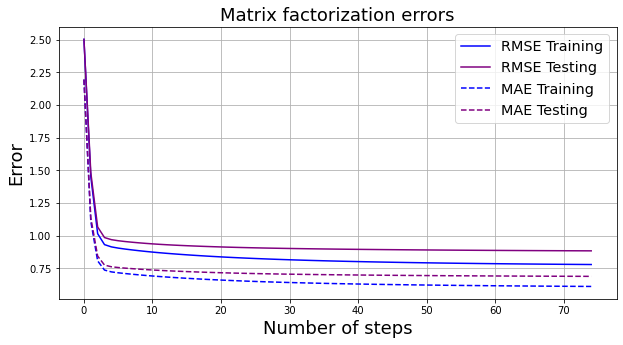

In [43]:
training_steps = np.arange(n_training_steps)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(training_steps, mean_train_rmses, label='RMSE Training', c='blue', linestyle='-')
ax.plot(training_steps, mean_test_rmses, label='RMSE Testing', c='purple', linestyle='-')
ax.plot(training_steps, mean_train_maes, label='MAE Training', c='blue' ,linestyle='--')
ax.plot(training_steps, mean_test_maes, label='MAE Testing', c='purple' ,linestyle='--')
ax.grid()
ax.set_xlabel('Number of steps', fontsize=18)
ax.set_ylabel('Error', fontsize=18)
ax.set_title('Matrix factorization errors', fontsize=18)

plt.legend(fontsize='x-large')

plt.savefig('matrixfactorization_errors.png')
plt.show()

# Comparing all the models

In [47]:
d_1 = {'Model': ['Global Average', 'Movie Average', 'User Average' , 'LR with inter' , 'LR without inter','UV Decomp','Matrix Factor'], 
     'RMSE Training': [train_rmse_1, train_rmse_2, train_rmse_3, train_rmse_4, train_rmse_5,best_rmse_train_uv,best_train_rmse_mtx], 
    'RMSE Testing': [test_rmse_1, test_rmse_2, test_rmse_3, test_rmse_4, test_rmse_5,best_rmse_test_uv,best_test_rmse_mtx], 
    'MAE Training': [train_mae_1, train_mae_2, train_mae_3, train_mae_4, train_mae_5,best_mae_train_uv,best_train_mae_mtx], 
    'MAE Testing': [test_mae_1, test_mae_2, test_mae_3, test_mae_4, test_mae_5,best_mae_test_uv,best_test_mae_mtx],
    'Running Time': [RunTime_1,RunTime_2,RunTime_3,RunTime_4,RunTime_5,time_uv,run_time_mtx],
    'Memory': [Memory_1/(1e6),Memory_2/(1e6),Memory_3/(1e6),Memory_4/(1e6),Memory_5/(1e6),memory_uv/(1e6),memory_mtx/(1e6)]}
compare=pd.DataFrame(d_1)
compare_sorted=compare.sort_values(by=['RMSE Testing'],ascending=False)

In [48]:
compare

,Model,RMSE Training,RMSE Testing,MAE Training,MAE Testing,Running Time,Memory
0,Global Average,1.117101,1.117101,0.933861,0.933861,15.330006,375.525376
1,Movie Average,0.974211,0.979527,0.778343,0.782385,88.706646,389.423104
2,User Average,1.027672,1.035489,0.822732,0.829008,55.217570,389.443584
3,LR with inter,0.914544,0.924395,0.724800,0.732557,178.777820,416.600064
4,LR without inter,0.946550,0.952529,0.758551,0.763207,172.274426,447.537152
5,UV Decomp,0.862465,0.871110,0.823835,0.827818,822.068901,1948.037120
6,Matrix Factor,0.779890,0.884506,0.612083,0.689269,1190.862185,2054.627328


In [49]:
compare.to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\n           Model &  RMSE Training &  RMSE Testing &  MAE Training &  MAE Testing &  Running Time &      Memory \\\\\n\\midrule\n  Global Average &       1.117101 &      1.117101 &      0.933861 &     0.933861 &     15.330006 &  375.525376 \\\\\n   Movie Average &       0.974211 &      0.979527 &      0.778343 &     0.782385 &     88.706646 &  389.423104 \\\\\n    User Average &       1.027672 &      1.035489 &      0.822732 &     0.829008 &     55.217570 &  389.443584 \\\\\n   LR with inter &       0.914544 &      0.924395 &      0.724800 &     0.732557 &    178.777820 &  416.600064 \\\\\nLR without inter &       0.946550 &      0.952529 &      0.758551 &     0.763207 &    172.274426 &  447.537152 \\\\\n       UV Decomp &       0.862465 &      0.871110 &      0.823835 &     0.827818 &    822.068901 & 1948.037120 \\\\\n   Matrix Factor &       0.779890 &      0.884506 &      0.612083 &     0.689269 &   1190.862185 & 2054.627328 \\\\\n\\bottomrule\n

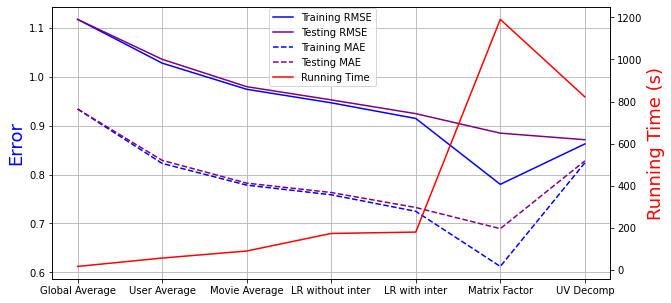

In [62]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(compare_sorted['Model'],compare_sorted['RMSE Training'],color='b',label='Training RMSE')
ax1.plot(compare_sorted['Model'],compare_sorted['RMSE Testing'],color='purple',label='Testing RMSE')
ax1.plot(compare_sorted['Model'],compare_sorted['MAE Training'],color='b',linestyle='--',label='Training MAE')
ax1.plot(compare_sorted['Model'],compare_sorted['MAE Testing'],color='purple',linestyle='--',label='Testing MAE')
ax2.plot(compare_sorted['Model'],compare_sorted['Running Time'],color='r',label='Running Time')
ax1.set_ylabel('Error', color='b',fontsize=18)
ax2.set_ylabel('Running Time (s)', color='r',fontsize=18)
ax1.grid()
fig.legend(loc=9,bbox_to_anchor=(0.50,0.89))
plt.savefig('comparison_time.png')
plt.show()

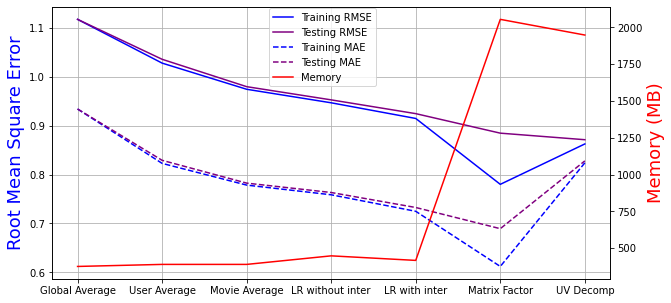

In [63]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(compare_sorted['Model'],compare_sorted['RMSE Training'],color='b',label='Training RMSE')
ax1.plot(compare_sorted['Model'],compare_sorted['RMSE Testing'],color='purple',label='Testing RMSE')
ax1.plot(compare_sorted['Model'],compare_sorted['MAE Training'],color='b',linestyle='--',label='Training MAE')
ax1.plot(compare_sorted['Model'],compare_sorted['MAE Testing'],color='purple',linestyle='--',label='Testing MAE')
ax2.plot(compare_sorted['Model'],compare_sorted['Memory'],color='r',label='Memory')
ax1.set_ylabel('Root Mean Square Error', color='b',fontsize=18)
ax2.set_ylabel('Memory (MB)', color='r',fontsize=18)
ax1.grid()
fig.legend(loc=9,bbox_to_anchor=(0.50,0.89))
plt.savefig('comparison_memory.png')
plt.show()